<a href="https://colab.research.google.com/github/OlyKoek/MyStudy-AI-app/blob/feature-update-ml/create_multimodal_embeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチモーダルなエンベディングモデルの作成
# Mini-CLIP: Text + Image shared embedding

- Text: multilingual MiniLM (TinyBERT)
- Image: MobileNetV3-Small
- Projection Head: 256 dimention shared space
- Loss: CLIP-style contrastive loss
- VectorStore: SimpleVetorDB    

# Install & Import

In [2]:
!pip install torch torchvision torchaudio --quiet
!pip install transformers umap-learn matplotlib pandas scikit-learn plotly --quiet
!pip install transformers --quiet

!pip install kaggle

import os
import json
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM

import torchvision.models as models
import torchvision.transforms as T

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import plotly.express as px

from PIL import Image
import requests
from IPython.display import display

DEVICE: cpu


# Config & Globl Define

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# Text Encorder Model
TEXT_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
EMBED_DIM = 256

# Decorder Model
DECODER_NAME = "google/flan-t5-small"

# Kaggle
from google.colab import userdata
os.environ["KAGGLE_USERNAME"] = userdata.get('username')
os.environ["KAGGLE_KEY"] = userdata.get('token')
!kaggle datasets list

ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                  Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           7005        154  1.0              
sonalshinde123/student-academic-performance-dataset               Student Academic Performance Dataset                     14999  2025-11-27 12:19:48.120000            864         26  1.0              
sadiajavedd/students-academic-performance-dataset                 Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          12280        304  1.0     

# Utils

In [4]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """
    ベクトル a, b のコサイン類似度を返すための関数
    """
    a_flat = a.flatten()
    b_flat = b.flatten()
    denom = (np.linalg.norm(a_flat) * np.linalg.norm(b_flat) + 1e-8)
    return float(np.dot(a_flat, b_flat) / denom)


def load_image(x):
    """
    Imageを読み込むための関数
    入力 x:
      - str(URL or file path)
      - PIL.Image.Image
    """
    if isinstance(x, Image.Image):
        return x.convert("RGB")

    if isinstance(x, str):
        if x.startswith("https://") or x.startswith("http://"):
            response = requests.get(x)
            img = Image.open(BytesIO(response.content))
            return img.convert("RGB")
        else:
            img = Image.open(x)
            return img.convert("RGB")

    raise ValueError(f"Unsupported image input type: {type(x)}")


def plot_umap_matplotlib(embs, labels, texts=None, title="UMAP"):
    """
    MatplotlibでUMAPを描画
    embs: (N, D) numpy array
    labels: list[str] same length as N
    texts:  list[str] hover表示用（任意）
    """
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="cosine")
    coords = reducer.fit_transform(embs)

    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(labels):
        plt.scatter(coords[i, 0], coords[i, 1])
        if texts is not None:
            plt.text(coords[i, 0], coords[i, 1], texts[i][:10], fontsize=8)
    plt.title(title)
    plt.show()


def plot_umap_plotly(embs, labels, texts=None, extra_meta=None, title="UMAP (Interactive)"):
    """
    PlotlyでインタラクティブなUMAPを描画
    """
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="cosine")
    coords = reducer.fit_transform(embs)

    data = {
        "x": coords[:, 0],
        "y": coords[:, 1],
        "type": labels,
    }
    if texts is not None:
        data["text"] = texts
    if extra_meta is not None:
        for k, v in extra_meta.items():
            data[k] = v

    df = pd.DataFrame(data)
    fig = px.scatter(
        df,
        x="x",
        y="y",
        color="type",
        hover_data=list(data.keys()),
        title=title,
        width=800,
        height=600,
    )
    fig.show()


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')


## Core Classes
- TextEncoder
- ImageEncoder
- MiniCLIP
- SimpleVectorDB

In [5]:
class TextEncoder(nn.Module):
    """
    TinyBERT系でテキストをエンコードするクラス
    Linear Projectionで256次元に射影変換
    """
    def __init__(self, model_name: str, out_dim: int = EMBED_DIM, device: torch.device = DEVICE):
        super().__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        hidden = self.model.config.hidden_size
        self.projector  = nn.Linear(hidden, out_dim).to(device)

    def forward(self, inputs):
        """
        HuggingFaceスタイルのForward関数を参考に実装
        B: バッチサイズ
        3: チャネル数(RGB)
        H, W: 画像の高さと幅
        T: トークン数
        H: モデルの隠れ層次元数
        out_dim: 射影後の次元数
        """
        outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # (B, T, H) -> (B, H)
        projected = self.projector(embeddings)  # (B, out_dim)
        return projected

    def encode(self, texts, normalize: bool = True) -> torch.Tensor:
        """
        textsをエンコードしてベクトルを返す関数

        texts: list[str]
        normalize: bool - 出力ベクトルを正規化するかどうか
        """
        if isinstance(texts, str):
            texts = [texts]

        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            emb = outputs.last_hidden_state.mean(dim=1)  # (B, H)

        proj = self.projector(emb)  # (B, out_dim)

        if normalize:
            proj = proj / (proj.norm(dim=1, keepdim=True) + 1e-8)

        return proj

In [6]:
class ImageEncoder(nn.Module):
    """
    MobileNetV3-Smallで画像をエンコードするクラス
    Linear Projectionで256次元に射影変換
    """
    def __init__(self, out_dim: int = EMBED_DIM, device: torch.device = DEVICE):
        super().__init__()
        self.device = device
        self.model = models.mobilenet_v3_small(pretrained=True)
        self.model.eval()
        self.features = self.model.features.to(device)
        self.projector = nn.Linear(576, out_dim).to(device)  # MobileNetV3-Smallの最終特徴量次元数は576

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
        ])

    def encode(self, images, normalize: bool = True) -> torch.Tensor:
        """
        画像リストをエンコードしてベクトルを返す関数

        images: list[PIL.Image.Image] または 単一のPIL.Image.Image
        normalize: bool - 出力ベクトルを正規化するかどうか
        """
        single = False
        if not isinstance(images, (list, tuple)):
            images = [images]
            single = True

        tensors = []
        for img in images:
            pil_img = load_image(img)
            tensor = self.transform(pil_img) # (3, H, W)
            tensors.append(tensor)
        batch = torch.stack(tensors, dim=0).to(self.device)  # (B, 3, H, W)

        with torch.no_grad():
            feat = self.features(batch)  # (B, 576, 7, 7)
            feat = feat.mean(dim=[2, 3])  # (B, 576)

        proj = self.projector(feat)  # (B, out_dim)

        if normalize:
            proj = proj / (proj.norm(dim=1, keepdim=True) + 1e-8)

        if single:
            return proj # (1, out_dim)
        return proj  # (B, out_dim)

In [7]:
class MiniCLIP:
    """
    TextEncoder と ImageEncoder を共有 256次元空間に揃え、
    CLIP風の対照学習で projector 層のみを学習するクラス。
    """
    def __init__(self, text_encoder: TextEncoder, image_encoder: ImageEncoder, temperature: float = 0.07):
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature

        params = list(self.text_encoder.projector.parameters()) + \
                 list(self.image_encoder.projector.parameters())
        self.optimizer = AdamW(params, lr=1e-4)


    def compute_loss(self, img_vecs: torch.Tensor, txt_vecs: torch.Tensor) -> torch.Tensor:
        """
        CLIP風の対照学習の損失を計算する関数
        img_vecs: (B, D)
        txt_vecs: (B, D)
        """
        # 類似度行列[B, B]を計算
        sim_matrix = torch.matmul(img_vecs, txt_vecs.T)
        sim_matrix = sim_matrix / self.temperature

        labels = torch.arange(len(img_vecs), device=sim_matrix.device)

        loss_img2txt = F.cross_entropy(sim_matrix, labels)
        loss_txt2img = F.cross_entropy(sim_matrix.T, labels)

        loss = (loss_img2txt + loss_txt2img) / 2.0
        return loss


    def train(self, pairs, epochs=10, batch_size=32):
        """
        学習を実行する関数
        pairs: list of (PIL.Image.Image, str)
        """
        n = len(pairs)

        for epoch in range(epochs):
            perm = np.random.permutation(n)
            epoch_loss = 0.0

            for start in range(0, n, batch_size):
                end = start + batch_size
                idx = perm[start:end]

                batch = [pairs[i] for i in idx]
                texts  = [p["text"]  for p in batch]
                images = [p["image"] for p in batch]

                # normalize=False → CLIP の標準
                txt_vecs = self.text_encoder.encode(texts, normalize=False)
                img_vecs = self.image_encoder.encode(images, normalize=False)

                loss = self.compute_loss(img_vecs, txt_vecs)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item() * len(batch)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/n:.4f}")

        print("Training completed.")

In [25]:
# # -----------------------------
# # Prepare tokenizer & training data for text decoder
# # -----------------------------

# from transformers import AutoTokenizer
# tokenizer_lm = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)

# # 学習用：MemeCap のテキストだけ集める
# train_texts = [p["text"] for p in pairs]

# def encode_text_for_decoder(text, max_len=20):
#     t = tokenizer_lm(
#         text,
#         padding="max_length",
#         truncation=True,
#         max_length=max_len,
#         return_tensors="pt"
#     )
#     ids = t["input_ids"][0]  # (max_len)
#     return ids


In [36]:
class TransformerTextDecoder(nn.Module):
    def __init__(self, embed_dim, vocab_size, hidden_dim=256, num_layers=3, max_len=40, device="cpu"):
        super().__init__()
        self.device = device
        self.max_len = max_len

        # --- 1) Token embedding ---
        self.embed = nn.Embedding(vocab_size, embed_dim)

        # --- 2) Positional encoding ---
        self.pos_embed = nn.Embedding(max_len, embed_dim)

        # --- 3) Transformer decoder ---
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=False  # (T,B,D) 形式で処理する
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # --- 4) vocab projection ---
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, memory, tgt):
        """
        memory: (1,1,256)
        tgt:    (1, T)
        """
        B, T = tgt.shape

        # ---- 1) token embedding ----
        tgt_emb = self.embed(tgt)         # (1,T,256)

        # ---- 2) add position ----
        pos_ids = torch.arange(T, device=self.device).unsqueeze(0)  # (1,T)
        pos_emb = self.pos_embed(pos_ids)  # (1,T,256)

        tgt_emb = tgt_emb + pos_emb       # (1,T,256)

        # ---- 3) Transformer expects (T,B,256) ----
        tgt_emb = tgt_emb.transpose(0, 1)  # (T,1,256)

        # ---- 4) decode ----
        out = self.decoder(tgt=tgt_emb, memory=memory)   # (T,1,256)

        # ---- 5) vocab projection ----
        out = self.fc(out)  # (T,1,vocab)

        return out


In [10]:
class SimpleVectorDB:
    """
    非常にシンプルなベクトルストア。
    - items: List[{"vec": np.ndarray, "type": ..., "text": ..., "image": ...}]
    """
    def __init__(self):
        self.items = []

    def add(self, vec: np.ndarray, metadata: dict):
        self.items.append({
            "vec": vec.astype("float32"),
            **metadata
        })

    def build_from_pairs(self, text_encoder, image_encoder, pairs):
        self.items = []
        for p in pairs:
            text = p["text"]
            img = p["image"]
            img_path = p.get("image_path", None)

            # text embedding
            t_vec = text_encoder.encode(text).cpu().detach().numpy()[0]
            self.add(t_vec, {
                "type": "text",
                "text": text,
                "image_path": img_path,
            })

            # image embedding
            i_vec = image_encoder.encode(img).cpu().detach().numpy()[0]
            self.add(i_vec, {
                "type": "image",
                "text": text,
                "image_path": img_path,
            })


    def search(self, query_vec: np.ndarray, top_k: int = 5, type_filter: str = None):
        """
        query_vec: np.ndarray [D]
        type_filter: "text" or "image" or None
        """
        results = []
        for item in self.items:
            if type_filter is not None and item["type"] != type_filter:
                continue
            sim = cosine_sim(query_vec, item["vec"])
            results.append((sim, item))

        results.sort(key=lambda x: x[0], reverse=True)
        return results[:top_k]

    def to_jsonable(self):
          json_items = []
          for item in self.items:
              j = dict(item)
              j.pop("image", None)
              j["vec"] = item["vec"].tolist()
              json_items.append(j)
          return json_items

    @staticmethod
    def from_json(data):
        db = SimpleVectorDB()
        for item in data:
            vec = np.array(item["vec"], dtype="float32")
            meta = {k: v for k, v in item.items() if k != "vec"}
            db.add(vec, meta)
        return db



# Decorder

In [73]:
tiny_tok = AutoTokenizer.from_pretrained(DECODER_NAME)
tiny_model = AutoModelForSeq2SeqLM.from_pretrained(DECODER_NAME).to(DEVICE)

def generate_tiny_summary(user_query, related_texts, lang="en", max_new_tokens=48):
    context = " | ".join(related_texts)

    prompt = (
        "Write a short, abstract English explanation describing the feeling or mood.\n"
        "Do NOT copy the original sentences.\n"
        f"User Input: {user_query}\n"
        f"Related Meme Captions: {context}\n"
        "Explanation:"
    )

    inputs = tiny_tok(prompt, return_tensors="pt", truncation=True).to(DEVICE)

    outputs = tiny_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.9,
        temperature=0.8,
    )
    return tiny_tok.decode(outputs[0], skip_special_tokens=True)


def explain_with_decoder(query_text=None, query_image=None, top_k=3):
    """
    Text or Image → MiniCLIP → VectorDB検索 → T5要約
    """
    assert query_text or query_image

    # --- Step1: エンコード ---
    if query_text:
        query_vec = text_encoder.encode(query_text).detach().cpu().numpy()[0]
    else:
        img = load_image(query_image)
        query_vec = image_encoder.encode(img).detach().cpu().numpy()[0]

    # --- Step2: VectorDB検索 ---
    results = vecdb.search(query_vec, top_k=top_k)

    # --- Step3: 英語説明文を取り出す ---
    related_texts = [item["text"] for _, item in results]

    # --- Step4: T5 で短い説明生成 ---
    generated = generate_tiny_summary(
        user_query=query_text or "(image query)",
        related_texts=related_texts,
    )

    return {
        "query_text": query_text,
        "related_texts": related_texts,
        "generated": generated
    }

# Dataset

In [11]:
# # @title
# class ArtBenchDatasetLoader:
#     """
#     ArtBench-10 (CIFAR形式) ローダー
#     - b"data" / "data" どちらにも対応
#     - Kaggle版 / GitHub版 どちらも対応
#     """

#     def __init__(self, root_dir, limit_per_class=200, shuffle=True):
#         self.root = root_dir
#         self.limit = limit_per_class
#         self.shuffle = shuffle

#         # Python版のデータディレクトリ
#         self.py_dir = os.path.join(root_dir, "artbench-10-python", "artbench-10-batches-py")

#         # クラス名は meta ファイルから読み込み
#         meta_path = os.path.join(self.py_dir, "meta")
#         meta = unpickle(meta_path)

#         # meta は {b"styles": [...]} or {"styles": [...]} のどちらか
#         if b"styles" in meta:
#             self.styles = [s.decode("utf-8") for s in meta[b"styles"]]
#         else:
#             self.styles = meta["styles"]

#         print("Loaded styles:", self.styles)

#     def _get(self, batch, key):
#         """
#         batch[b"data"] と batch["data"] 両方に対応するヘルパー
#         """
#         if key in batch:
#             return batch[key]
#         if key.encode() in batch:
#             return batch[key.encode()]
#         raise KeyError(f"key {key} not found in batch")

#     def _load_batch(self, file_path):
#         batch = unpickle(file_path)

#         data = self._get(batch, "data").reshape(-1, 3, 32, 32)
#         labels = self._get(batch, "labels")
#         return data, labels

#     def _to_pil(self, arr):
#         img = np.transpose(arr, (1,2,0))
#         return Image.fromarray(img.astype(np.uint8))

#     def load(self):
#         batch_files = sorted([
#             os.path.join(self.py_dir, f)
#             for f in os.listdir(self.py_dir)
#             if f.startswith("data_batch") or f=="test_batch"
#         ])

#         pairs = []
#         per_class = {i:0 for i in range(10)}

#         for bf in batch_files:
#             data, labels = self._load_batch(bf)

#             for i, lid in enumerate(labels):
#                 if per_class[lid] >= self.limit:
#                     continue

#                 img = self._to_pil(data[i])
#                 text = f"{self.styles[lid]} の絵画"

#                 pairs.append({
#                     "image": img,
#                     "text": text,
#                 })

#                 per_class[lid] += 1

#         if self.shuffle:
#             np.random.shuffle(pairs)

#         print("Loaded", len(pairs), "image-text pairs")
#         return pairs


In [12]:
import json
import os
from PIL import Image
import numpy as np

class MemeCapLoader:
    def __init__(self, root_dir, split="train", limit=None, shuffle=True, text_mode="meme"):
        self.root = root_dir
        self.split = split
        self.limit = limit
        self.shuffle = shuffle
        self.text_mode = text_mode

        json_name = "memes-trainval.json" if split == "train" else "memes-test.json"
        json_path = os.path.join(root_dir, json_name)

        with open(json_path, "r") as f:
            self.data = json.load(f)

        print(f"[MemeCap] loaded {len(self.data)} items")

        # 画像ファイルを全探索して index を作る
        self.image_index = self._build_image_index()

    def _build_image_index(self):
        print("[MemeCap] scanning image files...")
        index = {}
        for dirpath, _, filenames in os.walk(self.root):
            for fname in filenames:
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    index[fname] = os.path.join(dirpath, fname)
        print(f"[MemeCap] found {len(index)} image files")
        return index

    def _select_text(self, item):
        if self.text_mode == "meme":
            return item["meme_captions"][0]
        elif self.text_mode == "image":
            return item["img_captions"][0]
        elif self.text_mode == "title":
            return item["title"]
        elif self.text_mode == "mixed":
            return f"{item['title']} / {item['img_captions'][0]} / {item['meme_captions'][0]}"
        else:
            return item["meme_captions"][0]

    def load(self):
        pairs = []
        data_iter = self.data if self.limit is None else self.data[:self.limit]

        for item in data_iter:
            fname = item["img_fname"]
            img_path = self.image_index.get(fname)
            if not img_path:
                continue

            try:
                img = Image.open(img_path).convert("RGB")
            except:
                continue

            text = self._select_text(item)
            pairs.append({"image": img, "image_path": img_path, "text": text})

        if self.shuffle:
            np.random.shuffle(pairs)

        print(f"[MemeCap] Loaded {len(pairs)} pairs")
        return pairs


# MiniClip作って学習

In [19]:
# DownloadDataset
# !mkdir -p ./artbench
# !kaggle datasets download alexanderliao/artbench10 -p ./artbench --unzip

# !mkdir -p ./meme
# !kaggle datasets download harshittiwari007/meme-convx -p ./meme --unzip


Dataset URL: https://www.kaggle.com/datasets/harshittiwari007/meme-convx
License(s): ODC Attribution License (ODC-By)
 99% 1.55G/1.57G [00:12<00:00, 271MB/s]
100% 1.57G/1.57G [00:12<00:00, 132MB/s]


[MemeCap] loaded 5823 items
[MemeCap] scanning image files...
[MemeCap] found 6416 image files
[MemeCap] Loaded 500 pairs
pairs: 500


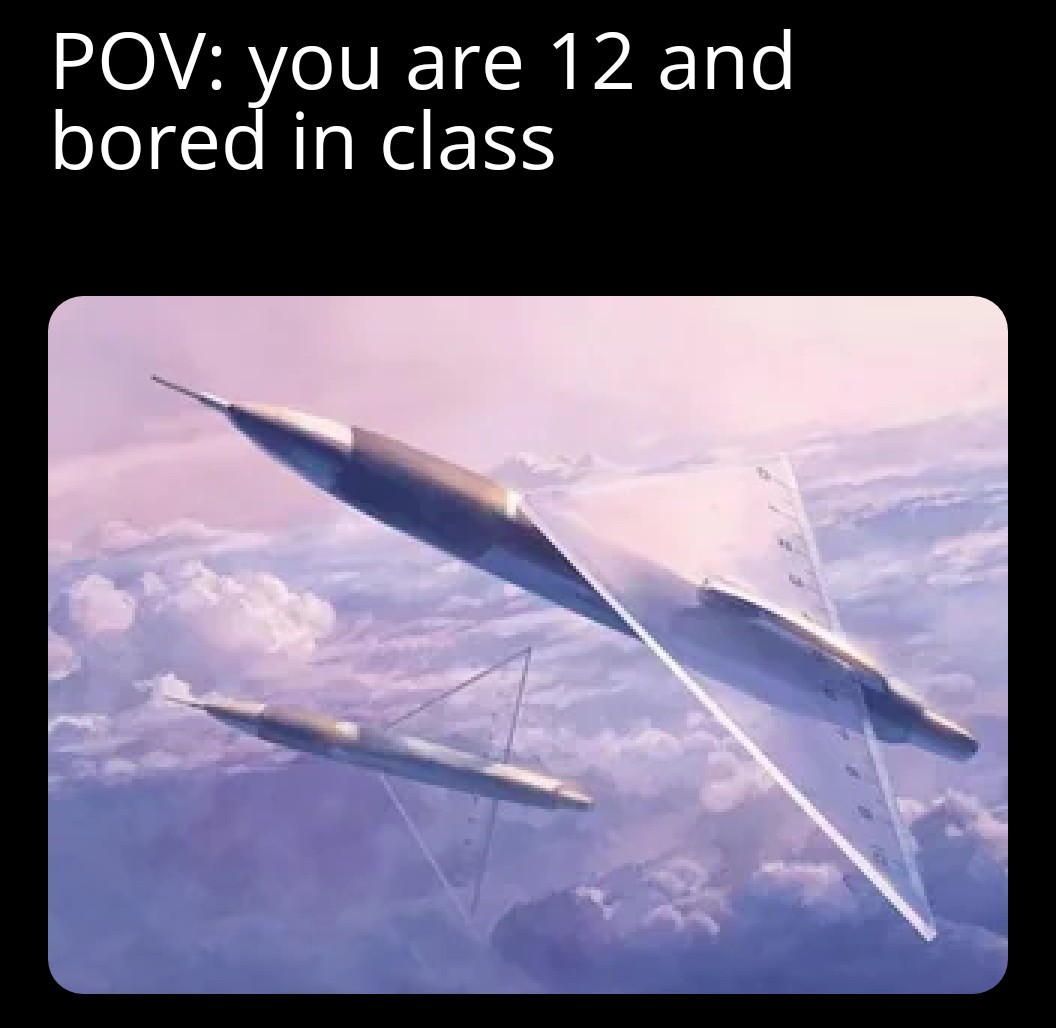

./meme/memes/memes/memes/memes_v0uks9.png
Meme poster is bored in class so is daydreaming about their supplies.


In [20]:
loader = MemeCapLoader(
    "./meme",
    split="train",
    limit=1000,        # とりあえず軽く
    text_mode="meme",  # まずはミームの意味キャプションで
)

pairs = loader.load()
print("pairs:", len(pairs))
display(pairs[0]["image"])
print(pairs[0]["image_path"])
print(pairs[0]["text"])


In [21]:
# MiniCLIPモデルを初期化
text_encoder = TextEncoder(TEXT_MODEL_NAME, EMBED_DIM, DEVICE)
image_encoder = ImageEncoder(EMBED_DIM, DEVICE)
mini_clip = MiniCLIP(text_encoder, image_encoder)

# 学習開始
print("Mini-CLIP training start...")
mini_clip.train(pairs, epochs=30, batch_size=32)
print("Done!")

Mini-CLIP training start...
Epoch 1/10, Loss: 9.7154
Epoch 2/10, Loss: 7.0638
Epoch 3/10, Loss: 5.7454
Epoch 4/10, Loss: 4.5249
Epoch 5/10, Loss: 3.8318
Epoch 6/10, Loss: 3.1355
Epoch 7/10, Loss: 2.4927
Epoch 8/10, Loss: 2.2253
Epoch 9/10, Loss: 1.7920
Epoch 10/10, Loss: 1.4555
Training completed.
Done!


In [22]:
# from transformers import MBart50TokenizerFast, MBartForConditionalGeneration

# # 無料で使える多言語翻訳モデル
# TRANS_MODEL_NAME = "facebook/mbart-large-50-many-to-many-mmt"

# trans_tokenizer = MBart50TokenizerFast.from_pretrained(TRANS_MODEL_NAME)
# trans_model = MBartForConditionalGeneration.from_pretrained(TRANS_MODEL_NAME).to(DEVICE)

# def translate_to_japanese(text):
#     # 英語 → 日本語翻訳
#     trans_tokenizer.src_lang = "en_XX"
#     encoded = trans_tokenizer(text, return_tensors="pt").to(DEVICE)
#     generated_tokens = trans_model.generate(
#         **encoded,
#         forced_bos_token_id=trans_tokenizer.lang_code_to_id["ja_XX"]
#     )
#     return trans_tokenizer.decode(generated_tokens[0], skip_special_tokens=True)


# VectorDB構築＆検索＆可視化

In [32]:
# VectorDB構築
vecdb = SimpleVectorDB()
vecdb.build_from_pairs(text_encoder, image_encoder, pairs)
print(f"VectorDB size: {len(vecdb.items)} items")

VectorDB size: 1000 items


# VectorDBテスト

sim=0.444 | type=text | text=Poster is sad it is November. 


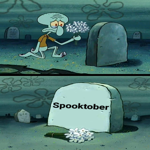

sim=0.439 | type=text | text=Meme poster is feeling sad.


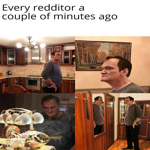

sim=0.432 | type=text | text=Meme poster is just giving their take on how depressing they feel the world is, so depressing that the pigeons even see it.


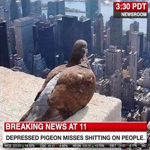

sim=0.411 | type=text | text=Meme poster is trying to convey that they feel sorry for amusement park workers who have to deal with angry mothers all day.


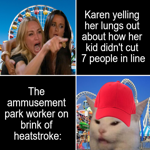

sim=0.407 | type=text | text=Meme poster is trying to convey the disappointment they feel in not getting to learn what they want to learn.


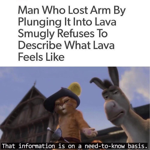

In [33]:
# テキストでクエリ
query_text = "今日は本当にめんどい"
query_vec = text_encoder.encode(query_text).detach().cpu().numpy()[0]

results = vecdb.search(query_vec, top_k=5)

for sim, item in results:
    print(f"sim={sim:.3f} | type={item['type']} | text={item['text']}")
    # display(item["image_path"].resize((150, 150)))
    img = Image.open(item["image_path"])
    display(img.resize((150,150)))


# imageでクエリ
# img = image_text_pairs[0]["image"]
# img_vec = image_encoder.encode(img).detach().cpu().numpy()[0]

# results = vecdb.search(img_vec, top_k=5)

# for sim, item in results:
#     print(f"sim={sim:.3f} | text={item['text']}")
#     display(item["image"].resize((150,150)))

In [72]:
result = explain_with_decoder(query_text="たくさんの猫が欲しい")

print(result)


{'query_text': 'たくさんの猫が欲しい', 'related_texts': ['Meme poster thinks that people on the internet really like cats', 'Meme poster is trying to convey that domesticated cats are spoiled and overweight compared to how they were in the wild.', 'Meme poster is trying to convey that the situation that kitten gets very angry.'], 'generated': 'A poster of the sex and the animal in the shelter reveals that a kitten gets very angry.'}


# UMAP 可視化

In [ ]:
embs = np.stack([it["vec"] for it in vecdb.items], axis=0)
labels = [it["type"] for it in vecdb.items]
texts = [it["text"] for it in vecdb.items]

# plot_umap_matplotlib(embs, labels, texts, title="Mini-CLIP: Dog Demo (Matplotlib)")
plot_umap_plotly(embs, labels, texts, title="Mini-CLIP: Dog Demo (Plotly)")


# Export image

In [ ]:
os.makedirs("artifacts", exist_ok=True)

# projector 保存
torch.save(text_encoder.projector.state_dict(), "text_projector.pt")
torch.save(image_encoder.projector.state_dict(), "image_projector.pt")

# VectorDB 保存
with open("vector_db.json", "w", encoding="utf-8") as f:
    json.dump(vecdb.to_jsonable(), f, ensure_ascii=False, indent=2)

print("Saved")

#### 日本語表示対応

In [ ]:
# # 日本語フォントをダウンロードする。
# !apt-get -y install fonts-ipafont-gothic
# import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'IPAGothic'

# import shutil
# import os
# # フォントキャッシュを削除
# font_cache_path = os.path.expanduser("~/.cache/matplotlib")
# if os.path.exists(font_cache_path):
#     shutil.rmtree(font_cache_path)